In [26]:
import yfinance as yf 
import pandas as pd 
from datetime import datetime, timedelta 
import numpy as np 
from scipy.optimize import minimize

In [27]:
tickers = ['SPY','NVDA','AAPL','MSFT','AMD', 'GOOGL', 'AMZN', 'TSLA', 'MU']
end_date = datetime.today()
start_date = end_date - timedelta(days = 2*365)

In [28]:
# Robust multi-ticker download with adjusted prices and MultiIndex handling
raw = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,           # adjusted already lives in 'Close'
    group_by="column",
    progress=False
)

# Extract adjusted price level for both old/new yfinance behaviors
if isinstance(raw.columns, pd.MultiIndex):
    lvl0 = raw.columns.get_level_values(0)
    want = "Adj Close" if "Adj Close" in lvl0 else "Close"
    adj_close_df = raw.xs(want, axis=1, level=0)
else:
    want = "Adj Close" if "Adj Close" in raw.columns else "Close"
    adj_close_df = raw[[want]]
    # If a single ticker was provided, rename the column to the ticker symbol
    if isinstance(tickers, list) and len(tickers) == 1:
        adj_close_df = adj_close_df.rename(columns={want: tickers[0]})

# Optional: align to business days and fill small gaps
adj_close_df = (
    adj_close_df.sort_index()
                .asfreq("B")
                .ffill(limit=3)
                .dropna(how="all")
)

print(f"Adjusted close DataFrame shape: {adj_close_df.shape}")
print(f"Columns in adj_close_df: {list(adj_close_df.columns)}")
if not adj_close_df.empty:
    print(f"Date range: {adj_close_df.index[0]} to {adj_close_df.index[-1]}")
    print(adj_close_df.head())
else:
    print("Error: No data was downloaded. Check tickers/date range/network.")

Adjusted close DataFrame shape: (522, 9)
Columns in adj_close_df: ['AAPL', 'AMD', 'AMZN', 'GOOGL', 'MSFT', 'MU', 'NVDA', 'SPY', 'TSLA']
Date range: 2023-08-17 00:00:00 to 2025-08-15 00:00:00
Ticker       AAPL    AMD   AMZN  GOOGL   MSFT    MU  NVDA    SPY   TSLA
Date                                                                   
2023-08-17 172.31 104.44 133.98 129.15 312.69 62.96 43.32 424.98 219.22
2023-08-18 172.80 105.45 133.22 126.70 312.29 62.99 43.27 425.18 215.49
2023-08-21 174.13 108.22 134.68 127.60 317.62 63.35 46.94 427.95 231.28
2023-08-22 175.51 105.66 134.25 128.31 318.19 62.81 45.64 426.79 233.19
2023-08-23 179.36 109.43 135.52 131.58 322.67 64.57 47.09 431.54 236.86


In [29]:
from typing import Any

class Console:
    @staticmethod
    def log(*args: Any) -> None:
        print(*args)

console = Console()
console.log("Code is", "Poetry")

Code is Poetry


In [30]:
# Compute log returns using diff of logs (fast & stable)
if adj_close_df.empty:
    print("Error: adj_close_df is empty; cannot compute log returns.")
else:
    log_returns = np.log(adj_close_df).diff().dropna(how="all")
    print(f"Log returns shape: {log_returns.shape}")
    if not log_returns.empty:
        print(f"Date range: {log_returns.index[0]} to {log_returns.index[-1]}")
        print("First few log returns:\n", log_returns.head())
    else:
        print("Warning: Log returns DataFrame is empty after diff/dropna.")

Log returns shape: (521, 9)
Date range: 2023-08-18 00:00:00 to 2025-08-15 00:00:00
First few log returns:
 Ticker      AAPL   AMD  AMZN  GOOGL  MSFT    MU  NVDA   SPY  TSLA
Date                                                             
2023-08-18  0.00  0.01 -0.01  -0.02 -0.00  0.00 -0.00  0.00 -0.02
2023-08-21  0.01  0.03  0.01   0.01  0.02  0.01  0.08  0.01  0.07
2023-08-22  0.01 -0.02 -0.00   0.01  0.00 -0.01 -0.03 -0.00  0.01
2023-08-23  0.02  0.04  0.01   0.03  0.01  0.03  0.03  0.01  0.02
2023-08-24 -0.03 -0.07 -0.03  -0.02 -0.02 -0.02  0.00 -0.01 -0.03


In [31]:
# Annualized covariance matrix from log returns
try:
    if 'log_returns' not in globals() or log_returns.empty:
        print("Error: log_returns is not available or empty; compute it first.")
    else:
        cov_matrix = log_returns.cov() * 252
        print("Covariance matrix shape:", cov_matrix.shape)
        print("Tickers:", list(cov_matrix.columns))
        print("\nHead of covariance matrix:\n", cov_matrix.head())
except NameError:
    print("Error: log_returns not defined; run the log-returns cell first.")

Covariance matrix shape: (9, 9)
Tickers: ['AAPL', 'AMD', 'AMZN', 'GOOGL', 'MSFT', 'MU', 'NVDA', 'SPY', 'TSLA']

Head of covariance matrix:
 Ticker  AAPL  AMD  AMZN  GOOGL  MSFT   MU  NVDA  SPY  TSLA
Ticker                                                    
AAPL    0.07 0.06  0.04   0.04  0.03 0.05  0.05 0.03  0.07
AMD     0.06 0.24  0.07   0.07  0.05 0.14  0.15 0.05  0.12
AMZN    0.04 0.07  0.09   0.05  0.04 0.07  0.08 0.04  0.08
GOOGL   0.04 0.07  0.05   0.08  0.03 0.05  0.06 0.03  0.07
MSFT    0.03 0.05  0.04   0.03  0.05 0.05  0.06 0.03  0.05


In [32]:
# Portfolio performance metrics
import numpy as np

def standard_deviation(weights, cov_matrix):
    w = np.asarray(weights)
    return np.sqrt(w.T @ cov_matrix @ w)

def expected_return(weights, log_returns):
    w = np.asarray(weights)
    return np.sum(log_returns.mean().values * w) * 252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate=0.0):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [33]:
# Portfolio optimization (maximize Sharpe)
from scipy.optimize import minimize

risk_free_rate = 0.02  # 2%


def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

n_assets = len(adj_close_df.columns)
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)
bounds = tuple((0.0, 0.4) for _ in range(n_assets))
initial_weights = np.array([1.0 / n_assets] * n_assets)

if 'log_returns' in globals() and not log_returns.empty:
    optimized_results = minimize(
        neg_sharpe_ratio,
        initial_weights,
        args=(log_returns, cov_matrix, risk_free_rate),
        method='SLSQP',
        constraints=constraints,
        bounds=bounds,
    )
    print("Optimization success:", optimized_results.success)
    if not optimized_results.success:
        print("Message:", optimized_results.message)
else:
    print("Error: compute log_returns and cov_matrix before optimization.")

Optimization success: True


Optimal Weights:
AAPL: 0.0000
AMD: 0.0000
AMZN: 0.0000
GOOGL: 0.0000
MSFT: 0.2884
MU: 0.0000
NVDA: 0.4000
SPY: 0.3116
TSLA: 0.0000

Expected Annual Return: 0.4096
Expected Volatility: 0.2801
Sharpe Ratio: 1.3907


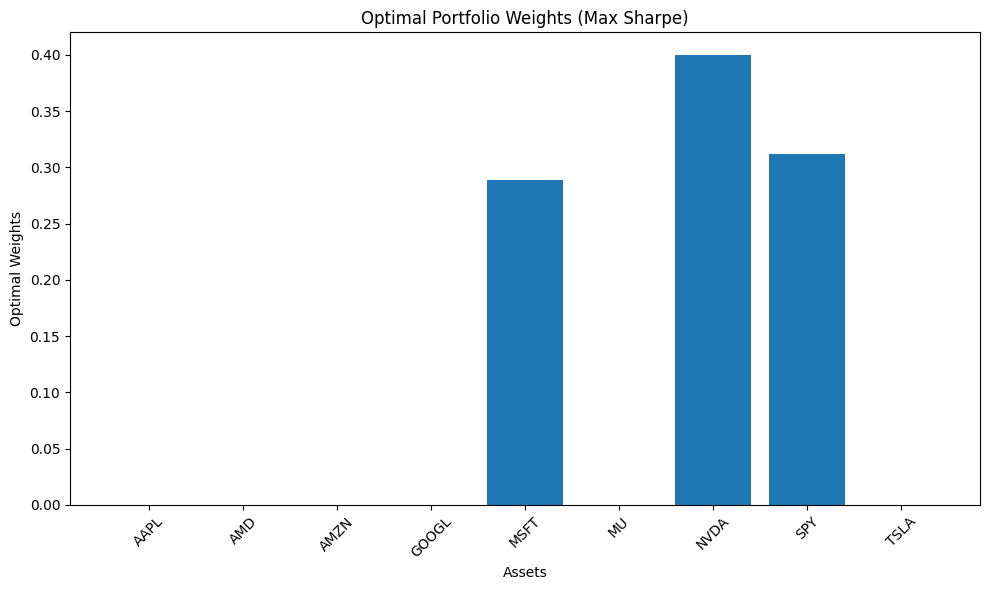

In [34]:
# Analyze the optimal portfolio and plot weights
import matplotlib.pyplot as plt

try:
    optimal_weights = optimized_results.x
    print("Optimal Weights:")
    for t, w in zip(adj_close_df.columns, optimal_weights):
        print(f"{t}: {w:.4f}")

    opt_ret = expected_return(optimal_weights, log_returns)
    opt_vol = standard_deviation(optimal_weights, cov_matrix)
    opt_sr = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

    print(f"\nExpected Annual Return: {opt_ret:.4f}")
    print(f"Expected Volatility: {opt_vol:.4f}")
    print(f"Sharpe Ratio: {opt_sr:.4f}")

    plt.figure(figsize=(10, 6))
    plt.bar(adj_close_df.columns, optimal_weights)
    plt.xlabel('Assets')
    plt.ylabel('Optimal Weights')
    plt.title('Optimal Portfolio Weights (Max Sharpe)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Optimization results not available:", str(e))

In [35]:
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s: %(message)s")
log = logging.getLogger("console")

log.info("Code is Poetry")

2025-08-16 15:59:02,240 INFO: Code is Poetry


Market-value weights (based on latest prices):
Ticker
AAPL    0.11
AMD     0.03
AMZN    0.01
GOOGL   0.04
MSFT    0.23
MU      0.06
NVDA    0.49
TSLA    0.03
dtype: float64

Holdings summary:
       quantity  avg_price  last_price  market_value  cost_basis  \
AAPL        105     217.00      231.59     24,316.95   22,785.00   
AMD          30     130.51      177.51      5,325.30    3,915.21   
AMZN          9     162.52      231.03      2,079.27    1,462.68   
GOOGL        40     160.56      203.90      8,156.00    6,422.36   
MSFT         95     413.80      520.17     49,416.15   39,310.62   
MU          100     132.76      120.87     12,087.00   13,276.00   
NVDA        580     123.03      180.45    104,661.00   71,359.72   
TSLA         19     259.10      330.56      6,280.64    4,922.88   

       unrealized_pnl  unrealized_pct  
AAPL         1,531.95            6.72  
AMD          1,410.09           36.02  
AMZN           616.59           42.15  
GOOGL        1,733.64           26.

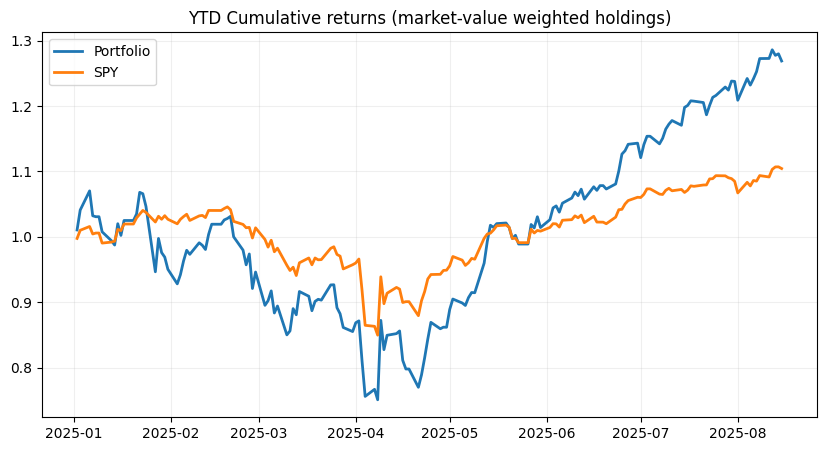

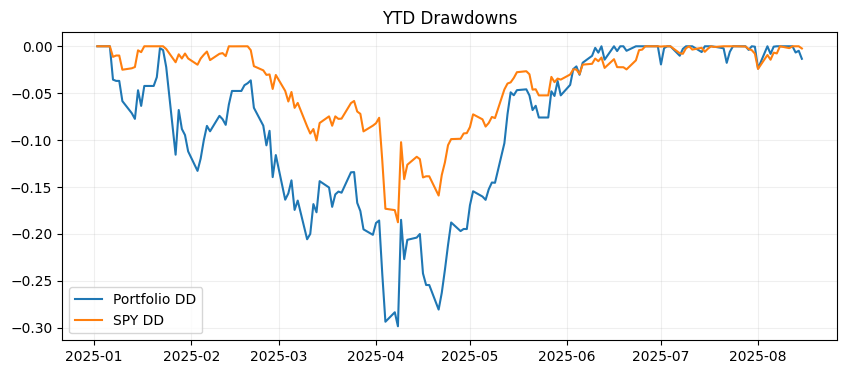


Exported `portfolio_from_holdings` dict (YTD + cost basis).


In [36]:
# --- Build portfolio weights from holdings (quantities) and compare vs SPY (Year-To-Date) ---
# Edit the `holdings` dict below to match your actual quantities from the screenshots.
holdings = {
    'AAPL': 105,
    'AMD': 30,
    'AMZN': 9,
    'GOOGL': 40,
    'MSFT': 95,
    'MU': 100,
    'NVDA': 580,
    'TSLA': 19,
}

# --- Average purchase prices (fill from your broker screenshots) ---
# Values taken from your screenshots; edit if different.
avg_prices = {
    'AAPL': 217.000,
    'AMD': 130.507,
    'AMZN': 162.520,
    'GOOGL': 160.559,
    'MSFT': 413.796,
    'MU': 132.760,
    'NVDA': 123.034,
    'TSLA': 259.099,
}

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
from datetime import datetime

# Ensure price index exists
try:
    prices = adj_close_df.copy()
except NameError:
    raise RuntimeError('adj_close_df not available in notebook; run your data download/processing cells first.')

# Make sure all tickers are in prices, otherwise download missing ones
miss = [t for t in holdings.keys() if t not in prices.columns]
if miss:
    print('Downloading missing tickers:', miss)
    data = yf.download(miss, start=prices.index.min(), end=prices.index.max(), progress=False, auto_adjust=True)
    if isinstance(data.columns, pd.MultiIndex):
        close = data.xs('Close', axis=1, level=1)
    else:
        close = data['Close'] if 'Close' in data.columns else data
    for t in miss:
        if t in close.columns:
            prices[t] = close[t].reindex(prices.index).ffill()

# Ensure SPY benchmark
benchmark = 'SPY'
if benchmark not in prices.columns:
    spy = yf.download(benchmark, start=prices.index.min(), end=prices.index.max(), progress=False, auto_adjust=True)
    prices[benchmark] = spy['Close'].reindex(prices.index).ffill()

# Determine YTD start and slice prices for returns calculation
ytd_start = pd.Timestamp(datetime.today().year, 1, 1)
prices_ytd = prices.loc[prices.index >= ytd_start]
if prices_ytd.empty:
    raise RuntimeError(f'No prices available for YTD starting {ytd_start.date()}; check data range.')

# Use most recent prices for market-value (current value)
last_prices = prices.iloc[-1][list(holdings.keys())]
quantities = pd.Series(holdings)
market_values = last_prices * quantities
weights = market_values / market_values.sum()
print('Market-value weights (based on latest prices):')
print(weights.round(4))

# Build avg_prices Series (ensure alignment)
avg_prices_series = pd.Series(avg_prices)
# If any avg price missing, fill with NaN
for t in holdings.keys():
    if t not in avg_prices_series:
        avg_prices_series[t] = np.nan
avg_prices_series = avg_prices_series[list(holdings.keys())]

# Cost basis and unrealized P/L
cost_basis = avg_prices_series * quantities
unrealized_pnl = market_values - cost_basis
unrealized_pct = (last_prices / avg_prices_series - 1.0) * 100.0

# Summary table per holding
holdings_df = pd.DataFrame({
    'quantity': quantities,
    'avg_price': avg_prices_series,
    'last_price': last_prices,
    'market_value': market_values,
    'cost_basis': cost_basis,
    'unrealized_pnl': unrealized_pnl,
    'unrealized_pct': unrealized_pct
})
# Nicely format
pd.options.display.float_format = '{:,.2f}'.format
print('\nHoldings summary:')
print(holdings_df)

# Compute returns over YTD and run analysis
rets = prices_ytd[list(holdings.keys()) + [benchmark]].pct_change().dropna(how='all')
# Align dates where benchmark exists
rets = rets.loc[~rets[benchmark].isna()]
port_rets = (rets[list(holdings.keys())] * weights.values).sum(axis=1)
bench_rets = rets[benchmark]

# Align
idx = port_rets.index.intersection(bench_rets.index)
port_rets = port_rets.loc[idx]
bench_rets = bench_rets.loc[idx]

cum_port = (1+port_rets).cumprod()
cum_bench = (1+bench_rets).cumprod()

excess = port_rets - bench_rets
tracking_error = excess.std(ddof=1) * np.sqrt(252)
active_return = excess.mean() * 252
information_ratio = active_return / tracking_error if tracking_error>0 else np.nan

mask = np.isfinite(port_rets) & np.isfinite(bench_rets)
if mask.sum() < 10:
    beta = np.nan
    alpha = np.nan
else:
    slope, intercept, r_value, p_value, std_err = stats.linregress(bench_rets[mask], port_rets[mask])
    beta = float(slope)
    alpha = float(intercept * 252)

# Drawdowns
def drawdown(s):
    rm = s.cummax()
    return (s - rm) / rm

dd_port = drawdown(cum_port)
dd_bench = drawdown(cum_bench)

# Totals
total_market_value = market_values.sum()
total_cost_basis = cost_basis.sum()
total_unrealized = unrealized_pnl.sum()

# Print results
print('\nPortfolio market value: ${:,.2f}'.format(total_market_value))
print('Total cost basis: ${:,.2f}'.format(total_cost_basis))
print('Unrealized P&L: ${:,.2f} ({:+.2f}%)'.format(total_unrealized, (total_unrealized/total_cost_basis)*100 if total_cost_basis>0 else np.nan))
print('YTD Period: {} to {}'.format(idx[0].date(), idx[-1].date()))
print('Portfolio YTD return (approx): {:.2%}'.format((cum_port.iloc[-1] - 1)))
print('Benchmark YTD return (approx): {:.2%}'.format((cum_bench.iloc[-1] - 1)))
print('Tracking error (ann): {:.4f}'.format(tracking_error))
print('Active return (ann): {:.4f}'.format(active_return))
print('Information ratio: {:.4f}'.format(information_ratio))
print('Beta: {:.4f}'.format(beta))

# Plots
plt.figure(figsize=(10,5))
plt.plot(cum_port, label='Portfolio', lw=2)
plt.plot(cum_bench, label=benchmark, lw=2)
plt.legend()
plt.grid(alpha=0.2)
plt.title('YTD Cumulative returns (market-value weighted holdings)')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(dd_port, label='Portfolio DD')
plt.plot(dd_bench, label=benchmark + ' DD')
plt.legend()
plt.grid(alpha=0.2)
plt.title('YTD Drawdowns')
plt.show()

# expose
holdings_weights = weights
portfolio_from_holdings = dict(
    holdings=holdings,
    quantities=quantities,
    avg_prices=avg_prices_series,
    weights=weights,
    market_values=market_values,
    cost_basis=cost_basis,
    unrealized_pnl=unrealized_pnl,
    unrealized_pct=unrealized_pct,
    total_market_value=total_market_value,
    total_cost_basis=total_cost_basis,
    total_unrealized=total_unrealized,
    portfolio_returns=port_rets,
    benchmark_returns=bench_rets,
    cum_port=cum_port,
    cum_bench=cum_bench,
    tracking_error=tracking_error,
    information_ratio=information_ratio,
    beta=beta,
    drawdown_port=dd_port,
    drawdown_bench=dd_bench,
    ytd_start=ytd_start
)
print('\nExported `portfolio_from_holdings` dict (YTD + cost basis).')
